PITCH MIX PREDICTIONS

In [ ]:
# Import all needed packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE


import pandas as pd

# Load the dataset

data_path = "/content/data.csv"
data = pd.read_csv(data_path)
data.head()



,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_PK,GAME_YEAR,GAME_DATE,...,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE,POST_AWAY_SCORE,POST_HOME_SCORE,POST_BAT_SCORE,POST_FLD_SCORE,DELTA_HOME_WIN_EXP,DELTA_RUN_EXP
0,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.038
1,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.049
2,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.052
3,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.113
4,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.077


In [ ]:
# Map pitch types to categories
pitch_mapping = {
    'FF': 'FB', 'FA': 'FB', 'FS': 'FB', 'FC': 'FB', 'SI': 'FB',  # Fastballs
    'SL': 'BB', 'CU': 'BB', 'KC': 'BB', 'SC': 'BB', 'ST': 'BB',  # Breaking Balls
    'CH': 'OS', 'FO': 'OS', 'SV': 'OS', 'KN': 'OS', 'EP': 'OS'   # Off-Speed
}

# Create a new column for pitch categories
data['PITCH_CATEGORY'] = data['PITCH_TYPE'].map(pitch_mapping)

# Remove rows with missing pitch categories if any(initial check showed there was none)
data.dropna(subset=['PITCH_CATEGORY'], inplace=True)

Exploratory Data Analysis

In [ ]:
# Check the structure of the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1285441 entries, 0 to 1286180
Data columns (total 57 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   PITCH_TYPE                       1285441 non-null  object 
 1   PITCH_NAME                       1285441 non-null  object 
 2   PLAYER_NAME                      1285441 non-null  object 
 3   BATTER_ID                        1285441 non-null  int64  
 4   PITCHER_ID                       1285441 non-null  int64  
 5   BAT_SIDE                         1285441 non-null  object 
 6   THROW_SIDE                       1285441 non-null  object 
 7   GAME_PK                          1285441 non-null  int64  
 8   GAME_YEAR                        1285441 non-null  int64  
 9   GAME_DATE                        1285441 non-null  object 
 10  HOME_TEAM                        1285441 non-null  object 
 11  AWAY_TEAM                        1285441 non-null  obje

In [ ]:
# Basic statistics of numeric columns
print(data.describe())

          BATTER_ID    PITCHER_ID       GAME_PK     GAME_YEAR        INNING  \
count  1.285441e+06  1.285441e+06  1.285441e+06  1.285441e+06  1.285441e+06   
mean   6.251212e+05  6.145204e+05  6.762402e+05  2.022122e+03  4.866700e+00   
std    5.490788e+04  6.180116e+04  3.524984e+04  8.087288e-01  2.627947e+00   
min    4.444820e+05  4.053950e+05  6.321690e+05  2.021000e+03  1.000000e+00   
25%    5.957770e+05  5.927670e+05  6.344450e+05  2.021000e+03  3.000000e+00   
50%    6.434460e+05  6.283170e+05  6.626830e+05  2.022000e+03  5.000000e+00   
75%    6.658330e+05  6.639410e+05  7.172290e+05  2.023000e+03  7.000000e+00   
max    8.077990e+05  7.016430e+05  7.187820e+05  2.023000e+03  1.600000e+01   

       AT_BAT_NUMBER  PITCH_NUMBER  OUTS_WHEN_UP         BALLS       STRIKES  \
count   1.285441e+06  1.285441e+06  1.285441e+06  1.285441e+06  1.285441e+06   
mean    3.780334e+01  2.920397e+00  9.771495e-01  8.897701e-01  8.946556e-01   
std     2.276415e+01  1.741633e+00  8.173326e-01

In [ ]:
# Check for any missing values in the dataset
missing_values = data.isnull().sum()
print("Missing Values Summary:\n", missing_values)

Missing Values Summary:
 PITCH_TYPE                               0
PITCH_NAME                               0
PLAYER_NAME                              0
BATTER_ID                                0
PITCHER_ID                               0
BAT_SIDE                                 0
THROW_SIDE                               0
GAME_PK                                  0
GAME_YEAR                                0
GAME_DATE                                0
HOME_TEAM                                0
AWAY_TEAM                                0
INNING                                   0
INNING_TOPBOT                            0
AT_BAT_NUMBER                            0
PITCH_NUMBER                             0
OUTS_WHEN_UP                             0
BALLS                                    0
STRIKES                                  0
ON_1B                               889291
ON_2B                              1044238
ON_3B                              1165971
IF_FIELDING_ALIGNMENT        

There are several missing value columns in the dataset. We'll deal with that in the subsequent columns.


In [ ]:
# Confirm the data comes from 2021-2023 MLB seasons
data.GAME_YEAR.unique()

array([2021, 2022, 2023], dtype=int64)

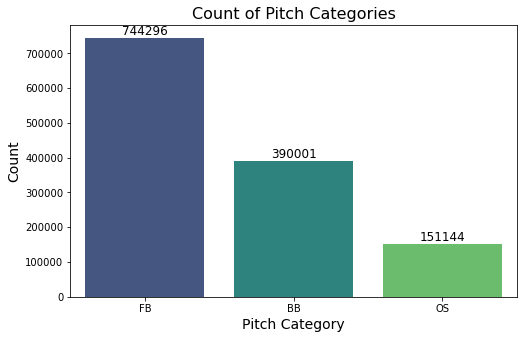

In [ ]:
# Check the count of fastballs, breaking balls ands offspeed in the dataset


plt.figure(figsize=(8, 5))  # Set the figure size

ax = sns.countplot(data=data, x='PITCH_CATEGORY', palette='viridis')  # Use 'viridis' palette for better aesthetics

# Adding titles and labels
plt.title('Count of Pitch Categories', fontsize=16)
plt.xlabel('Pitch Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adding count annotations on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

The data shows batters faced more fastballs than breaking balls and off-speed from 2021-2023.

FEATURE SELECTION PROCESS:

Using baseball knowledge and recent research works, it is obvious that some columns are irrelevant to predicting batter mixes.

I categorize the columns into these groups.

Events After the Pitch: EVENTS, DESCRIPTION, BB_TYPE, HIT_LOCATION, HC_X, HC_Y, HIT_DISTANCE_SC, LAUNCH_SPEED, LAUNCH_ANGLE, ESTIMATED_BA_USING_SPEEDANGLE,
ESTIMATED_WOBA_USING_SPEEDANGLE, WOBA_VALUE, WOBA_DENOM, BABIP_VALUE, ISO_VALUE, LAUNCH_SPEED_ANGLE:
These describe the outcome of the pitch or batted ball rather than the pitch itself, so they would not influence the pitch type.

Game Score and Win Expectancy Variables: HOME_SCORE, AWAY_SCORE, BAT_SCORE, FLD_SCORE, POST_AWAY_SCORE, POST_HOME_SCORE, POST_BAT_SCORE, POST_FLD_SCORE,
DELTA_HOME_WIN_EXP, DELTA_RUN_EXP: These are less likely to affect pitch selection directly

Base Runners:ON_1B, ON_2B, ON_3B: Eventhough the presence of runners on base might affect pitch selection,
especially with off-speed pitches to prevent stolen bases, they have a large percentage of missing values.
(ON_1B,ON_2B and ON_3B have 69.15%, 81.21% and 90.71% of observations missing). Even if we adopt imputation methods,
imputation will introduce too much uncertainty and potentially incorrect assumptions, which could negatively affect the model's performance.

While having baserunners can influence pitch selection, the overall influence may not be significant enough to justify keeping columns with such extensive missing values.

We drop base runners columns as well.

All other columns are considered from here.

<ipython-input-12-6ec11ae22263>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['PITCH_CATEGORY'] = data_cleaned['PITCH_CATEGORY'].astype('category')


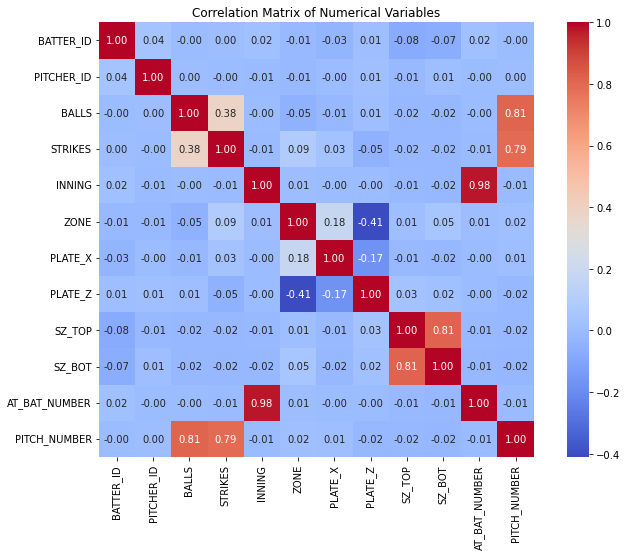

               BATTER_ID  PITCHER_ID     BALLS   STRIKES    INNING      ZONE  \
BATTER_ID       1.000000    0.036896 -0.002940  0.003022  0.022767 -0.013561   
PITCHER_ID      0.036896    1.000000  0.004862 -0.000597 -0.005599 -0.009846   
BALLS          -0.002940    0.004862  1.000000  0.380636 -0.002927 -0.050171   
STRIKES         0.003022   -0.000597  0.380636  1.000000 -0.005286  0.088411   
INNING          0.022767   -0.005599 -0.002927 -0.005286  1.000000  0.006287   
ZONE           -0.013561   -0.009846 -0.050171  0.088411  0.006287  1.000000   
PLATE_X        -0.033011   -0.001299 -0.014670  0.034801 -0.000002  0.180976   
PLATE_Z         0.008563    0.014724  0.010293 -0.049727 -0.000419 -0.411419   
SZ_TOP         -0.079431   -0.009193 -0.015545 -0.015572 -0.013695  0.010145   
SZ_BOT         -0.068496    0.011494 -0.015994 -0.018735 -0.016399  0.047447   
AT_BAT_NUMBER   0.023000   -0.003005 -0.001795 -0.006502  0.975849  0.006991   
PITCH_NUMBER   -0.000568    0.003490  0.

In [ ]:
#Select relevant columns based on baseball knowledge.
relevant_columns = [
    "BATTER_ID", "PITCHER_ID", "BAT_SIDE", "THROW_SIDE",
    "BALLS", "STRIKES", "INNING", "ZONE",
    "PLATE_X", "PLATE_Z", "SZ_TOP", "SZ_BOT",
    "IF_FIELDING_ALIGNMENT", "OF_FIELDING_ALIGNMENT", "AT_BAT_NUMBER",
    "PITCH_NUMBER", "PITCH_CATEGORY"
]

# Create a new DataFrame with only the relevant columns
data_cleaned = data[relevant_columns]

#  Ensure PITCH_CATEGORY is treated as categorical
data_cleaned['PITCH_CATEGORY'] = data_cleaned['PITCH_CATEGORY'].astype('category')

#  Select numerical variables for correlation analysis
# Convert categorical variables to numeric if needed for correlation
numerical_vars = data_cleaned.select_dtypes(include=[np.number])

#  Calculate the correlation matrix
correlation_matrix = numerical_vars.corr()

#  Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

#  Print the correlation matrix for reference
print(correlation_matrix)

Features with High Correlation:

PITCH_NUMBER with both BALLS (0.81) and STRIKES (0.79):  Given these high correlations, retaining only PITCH_NUMBER or one of the other two will be ideal.

AT_BAT_NUMBER and INNING: AT_BAT_NUMBER has a very high correlation with INNING (0.98), suggesting they provide similar information.

However, because multicollinearity is a problem mainly when interpreability is the main goal(as it increases standard errors and bias), I'll still keep correlated features to increase the model's predictive power.

Note that the model's predictive power isn't hugely impacted by multicollinearity.

In [ ]:
# I present two predictions approach. One involving no statistical modelling and the other involving modelling.

# Approach 1:

# Step 1: Calculate the mean probabilities for each pitch category by batter
# First, we will create a one-hot encoding of the PITCH_CATEGORY to compute means
data['PITCH_TYPE_FB'] = (data['PITCH_CATEGORY'] == 'FB').astype(int)
data['PITCH_TYPE_BB'] = (data['PITCH_CATEGORY'] == 'BB').astype(int)
data['PITCH_TYPE_OS'] = (data['PITCH_CATEGORY'] == 'OS').astype(int)

# Group by BATTER_ID and PLAYER_NAME, calculating the mean for each pitch type
mean_pitch_categories = data.groupby(['BATTER_ID', 'PLAYER_NAME']).agg(
    PITCH_TYPE_FB=('PITCH_TYPE_FB', 'mean'),
    PITCH_TYPE_BB=('PITCH_TYPE_BB', 'mean'),
    PITCH_TYPE_OS=('PITCH_TYPE_OS', 'mean')
).reset_index()

# Step 2: Add GAME_YEAR for prediction year (2024)
mean_pitch_categories['GAME_YEAR'] = 2024

# Step 3: Reorder the columns to match the submission format
submission = mean_pitch_categories[['BATTER_ID', 'PLAYER_NAME', 'GAME_YEAR', 'PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']]

# Display the first few rows of the submission DataFrame
print(submission.head(10))



   BATTER_ID        PLAYER_NAME  GAME_YEAR  PITCH_TYPE_FB  PITCH_TYPE_BB  \
0     444482     Peralta, David       2024       0.578200       0.269089   
1     453568  Blackmon, Charlie       2024       0.639213       0.231064   
2     456781    Solano, Donovan       2024       0.598464       0.312384   
3     457705  McCutchen, Andrew       2024       0.573162       0.324397   
4     457759     Turner, Justin       2024       0.626907       0.289680   
5     467793    Santana, Carlos       2024       0.574077       0.252317   
6     500743      Rojas, Miguel       2024       0.595636       0.320304   
7     502054        Pham, Tommy       2024       0.584720       0.311792   
8     502110     Martinez, J.D.       2024       0.577518       0.327030   
9     502671  Goldschmidt, Paul       2024       0.579265       0.343219   

   PITCH_TYPE_OS  
0       0.152711  
1       0.129723  
2       0.089153  
3       0.102441  
4       0.083413  
5       0.173606  
6       0.084061  
7       0.1

The naive prediction method calculates the average occurrence of each pitch type—Fastballs, Breaking Balls, and Off-Speed pitches—for every batter using historical data from 2021 to 2023. By mapping the pitch types to their respective categories and creating indicators, we can compute the mean probabilities for each batter facing each type of pitch. This approach offers a straightforward and interpretable way to generate predictions, serving as a baseline for evaluating more complex models. While it provides quick insights into batter-pitcher interactions, it assumes that past averages will predict future outcomes, which may not always hold true, and it overlooks contextual factors that could influence pitch selection.

In [ ]:
# Save to CSV
submission.to_csv("/root/naive_approach_predictions_2024.csv", index=False)  # Updated path

In [ ]:
# Check if every player was covered
len(submission)

314

In [ ]:
# 2nd Modelling Approach

**Characteristics of the data**
1. Observations are not independent since all players were studied more than once.
2. Data is unbalanced. That is,each player was recorded different number of times.
3. Heterogenous variances across the measurement time
4. The outcome variable is unbalanced.

The data tends to be longitudinal.

Due to the fact that the data is longitudinal, the brute force approach is linear mixed effects model with random intecept for multinomial logistic regression since:
1. It is robust to unbalanced data.
2. It allows analysis of between-player and within-player variation the responses.
3. Can control the positive correlation between repeated measures on the same subject

This same reason is why we can't use the most basic classification approach, the logistic regrssion because it requires observations in the data to be independent.

However, this traditional modelling technique is not suitable for large datasets running from the local computer like mine.

So we consider ML methods that capture complex relationships in the data that but have relaxed rules for data.

Steps:
1. First, train the model on 2021/2022 data and test it on 2023 using random forest regression.
2. Select the best model of the two based on classification metrics.
3. Fit the best model on all data (2021-2023) and predict.
4. Consider SMOTE(resampling method) to have a balanced class of the among the three responses to improve the model.
5. Optional: Fine-tune the model(if local computer space and running time will permit)



In [ ]:


# Step 1: Recreate pitch type mapping
pitch_mapping = {
    'FF': 'FB', 'FA': 'FB', 'FS': 'FB', 'FC': 'FB', 'SI': 'FB',  # Fastballs
    'SL': 'BB', 'CU': 'BB', 'KC': 'BB', 'SC': 'BB', 'ST': 'BB',  # Breaking Balls
    'CH': 'OS', 'FO': 'OS', 'SV': 'OS', 'KN': 'OS', 'EP': 'OS'   # Off-Speed
}

# Step 2: Map PITCH_TYPE to PITCH_CATEGORY
data['PITCH_CATEGORY'] = data['PITCH_TYPE'].map(pitch_mapping)
data.dropna(subset=['PITCH_CATEGORY'], inplace=True)  # Remove rows with NA values

# Step 3: Split the data into training and test sets
data['GAME_YEAR'] = pd.to_datetime(data['GAME_DATE']).dt.year  # Extract game year
train_data = data[(data['GAME_YEAR'] >= 2021) & (data['GAME_YEAR'] <= 2022)]
test_data = data[data['GAME_YEAR'] == 2023]

# Step 4: Select relevant columns for modeling
relevant_columns = [
    "BATTER_ID", "PITCHER_ID", "BAT_SIDE", "THROW_SIDE",
    "BALLS", "STRIKES", "INNING", "ZONE",
    "PLATE_X", "PLATE_Z", "SZ_TOP", "SZ_BOT",
    "IF_FIELDING_ALIGNMENT", "OF_FIELDING_ALIGNMENT", "AT_BAT_NUMBER",
    "PITCH_NUMBER", "PITCH_CATEGORY"
]

train_data_cleaned = train_data[relevant_columns]
test_data_cleaned = test_data[relevant_columns]

# Step 5: Prepare features and target variable for training
X_train = train_data_cleaned.drop(columns=['PITCH_CATEGORY'])
y_train = train_data_cleaned['PITCH_CATEGORY'].astype('category')  # Convert to categorical type

# Step 6: Map PITCH_CATEGORY to numerical values
y_train = y_train.map({'FB': 0, 'BB': 1, 'OS': 2})  # Mapping to numerical values for the model

X_test = test_data_cleaned.drop(columns=['PITCH_CATEGORY'])
y_test = test_data_cleaned['PITCH_CATEGORY'].astype('category')  # Convert to categorical type

# Map PITCH_CATEGORY to numerical values for testing
y_test = y_test.map({'FB': 0, 'BB': 1, 'OS': 2})  # Ensure the same mapping for test

# Step 7: One-Hot Encoding for categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Ensure the dimensions match after encoding
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


# Step 9: XGBoost Model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=123)
xgb_model.fit(X_train_encoded, y_train)
y_pred_xgb = xgb_model.predict(X_test_encoded)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Step 10: Random Forest Model
rf_model = RandomForestClassifier(random_state=123, n_estimators=100)
rf_model.fit(X_train_encoded, y_train)
y_pred_rf = rf_model.predict(X_test_encoded)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))







XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77    293225
           1       0.61      0.42      0.50    156793
           2       0.58      0.27      0.37     58592

    accuracy                           0.67    508610
   macro avg       0.63      0.52      0.55    508610
weighted avg       0.65      0.67      0.64    508610

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76    293225
           1       0.58      0.39      0.47    156793
           2       0.51      0.22      0.30     58592

    accuracy                           0.65    508610
   macro avg       0.59      0.49      0.51    508610
weighted avg       0.63      0.65      0.62    508610



Both models show decent performance in predicting fastballs but struggle with identifying breaking balls and off-speed pitches. The XGBoost model has better precision and recall for fastballs but lower performance for the other pitch types compared to the Random Forest model. The Random Forest model exhibits a stronger capability to identify fastballs but is less effective at detecting breaking balls and off-speed pitches, evidenced by lower recall scores. The accuracy of both models suggests there is room for improvement, especially for the minority classes (breaking balls and off-speed).

We'll use SMOTE to correct the problem of imbalanced classes. SMOTE is designed to improve the performance of machine learning algorithms when dealing with imbalanced datasets, where one class (e.g., a specific pitch type) is underrepresented compared to others. This can lead to biased predictions and poor performance on the minority class.


In [ ]:




# Step 2: Create pitch type mapping
pitch_mapping = {
    'FF': 'FB', 'FA': 'FB', 'FS': 'FB', 'FC': 'FB', 'SI': 'FB',  # Fastballs
    'SL': 'BB', 'CU': 'BB', 'KC': 'BB', 'SC' : 'BB', 'ST': 'BB',  # Breaking Balls
    'CH': 'OS', 'FO': 'OS', 'SV': 'OS', 'KN': 'OS', 'EP': 'OS'   # Off-Speed
}

# Step 3: Map PITCH_TYPE to PITCH_CATEGORY
data['PITCH_CATEGORY'] = data['PITCH_TYPE'].map(pitch_mapping)
data.dropna(subset=['PITCH_CATEGORY'], inplace=True)  # Remove rows with NA values

# Step 4: Assign numerical values to PITCH_CATEGORY
data['PITCH_CATEGORY'] = data['PITCH_CATEGORY'].map({'FB': 0, 'BB': 1, 'OS': 2})

# Step 5: Select relevant columns based on baseball knowledge
relevant_columns = [
    "BATTER_ID", "PITCHER_ID", "BAT_SIDE", "THROW_SIDE",
    "BALLS", "STRIKES", "INNING", "ZONE",
    "PLATE_X", "PLATE_Z", "SZ_TOP", "SZ_BOT",
    "IF_FIELDING_ALIGNMENT", "OF_FIELDING_ALIGNMENT", "AT_BAT_NUMBER",
    "PITCH_NUMBER", "PITCH_CATEGORY", "GAME_YEAR"
]

data_cleaned = data[relevant_columns]

# Step 6: Split the data into training and testing sets (2021-2022 as training and 2023 as testing)
train_data = data_cleaned[data_cleaned['GAME_YEAR'].isin([2021, 2022])]
test_data = data_cleaned[data_cleaned['GAME_YEAR'] == 2023]

X_train = train_data.drop(columns=['PITCH_CATEGORY','GAME_YEAR'])
y_train = train_data['PITCH_CATEGORY']

X_test = test_data.drop(columns=['PITCH_CATEGORY'])
y_test = test_data['PITCH_CATEGORY']

# Step 7: One-Hot Encoding for categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Step 8: Align train and test sets to ensure they have the same features
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Step 9: Handle missing values in the training set
X_train_encoded.fillna(0, inplace=True)  # Filling missing values with 0
X_test_encoded.fillna(0, inplace=True)  # Filling missing values with 0

# Step 10: Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Step 11: Train the Random Forest model using the resampled training data
rf_model = RandomForestClassifier(random_state=123, n_estimators=100)
rf_model.fit(X_train_resampled, y_train_resampled)

# Step 12: Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_encoded)

# Step 13: Evaluate the model
print("Random Forest Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_rf))

# Step 14: Train the XGBoost model using the resampled training data
xgb_model_smote = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=123)
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

# Step 15: Make predictions on the test data
y_pred_xgb = xgb_model_smote.predict(X_test_encoded)

# Step 16: Evaluate the model
print("XGBoost Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_xgb))


Random Forest Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.69      0.82      0.75    293225
           1       0.56      0.43      0.49    156793
           2       0.44      0.31      0.37     58592

    accuracy                           0.64    508610
   macro avg       0.57      0.52      0.54    508610
weighted avg       0.62      0.64      0.63    508610

XGBoost Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.70      0.83      0.76    293225
           1       0.60      0.46      0.52    156793
           2       0.51      0.34      0.41     58592

    accuracy                           0.66    508610
   macro avg       0.60      0.54      0.56    508610
weighted avg       0.65      0.66      0.64    508610



Actually, the SMOTE has similar results compared to when the classes were not balanced. This means both random forest and XGBoost are robust to unbalanced classes.

Similarly, XGBoost outperforms random forest here. Hence, we choose XGBoost as our preferred method or model and predict all the data from 2021-2023 on it. Our interest will be to get their respective probabilities for each pitch category and aggregate by their means for each batter player to get our pitch mix predictions.

In [ ]:
# From the first XGBoost model, make predictions on the entire dataset.

predictions_combined = xgb_model.predict_proba(X_encoded)

#  Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions_combined, columns=["PITCH_TYPE_FB", "PITCH_TYPE_BB", "PITCH_TYPE_OS"])

#  Combine predictions with batter information
result_df = pd.concat([data_cleaned[['BATTER_ID', 'PLAYER_NAME']], predictions_df], axis=1)

#  Add GAME_YEAR column
result_df['GAME_YEAR'] = 2024  # Assuming predictions are for 2024

# Aggregate results for submission format
submission = result_df.groupby(['BATTER_ID', 'PLAYER_NAME', 'GAME_YEAR']).agg({
    'PITCH_TYPE_FB': 'mean',
    'PITCH_TYPE_BB': 'mean',
    'PITCH_TYPE_OS': 'mean'
}).reset_index()

# Step 14: Display the first few rows of the submission DataFrame
print(submission.head(10))



   BATTER_ID        PLAYER_NAME  GAME_YEAR  PITCH_TYPE_FB  PITCH_TYPE_BB  \
0   444482.0     Peralta, David       2024       0.576983       0.305030   
1   453568.0  Blackmon, Charlie       2024       0.579769       0.309583   
2   456781.0    Solano, Donovan       2024       0.579336       0.302313   
3   457705.0  McCutchen, Andrew       2024       0.582664       0.302544   
4   457759.0     Turner, Justin       2024       0.575005       0.308514   
5   467793.0    Santana, Carlos       2024       0.579216       0.306275   
6   500743.0      Rojas, Miguel       2024       0.586386       0.297434   
7   502054.0        Pham, Tommy       2024       0.578207       0.302623   
8   502110.0     Martinez, J.D.       2024       0.579039       0.301966   
9   502671.0  Goldschmidt, Paul       2024       0.580370       0.299065   

   PITCH_TYPE_OS  
0       0.117987  
1       0.110648  
2       0.118351  
3       0.114792  
4       0.116481  
5       0.114509  
6       0.116180  
7       0.1

In [ ]:
# Check if every player was covered
len(submission)

314

In [ ]:
# Save to CSV
submission.to_csv("/root/xgboost_predictions_2024.csv", index=False)  # Updated path